# Simple 10 by 10 Grid Case
This notebook gives a brief overview on how to run simulation on simple grid shaped road network.

 First generate road network graph G and visualize it.

In [1]:
import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
import sys 
sys.path.append("../")
from graph_utils import *
G = generate_square_multidi_graph(10,10, mean_distance=400, std=100)

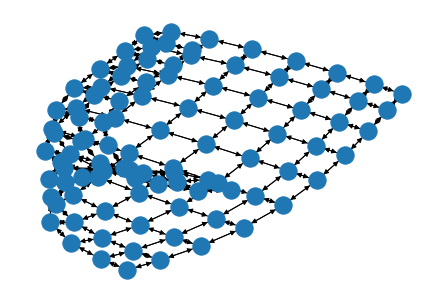

In [2]:
import matplotlib.pyplot as plt
nx.draw(G)
plt.draw()

Because above graph G is networkx Graph object, we need to convert it to dgl(deep graph library) Graph object. After conversion, let's transform the graph into its line graph.

In [3]:
import dgl
g = dgl.DGLGraph()
g.from_networkx(G, edge_attrs=['length', 'u', 'v'])
g_line = g.line_graph(shared=True)

Using backend: pytorch


Now let's train and evaluate on this road network. We will use four models as the papar(random, proportional, GCN_DQN, GAT_DQN). 
We will also test for different $\beta$s (policy_pows).

In [4]:
from main import *
from call_generator import RandomCallGenerator
from driver_initializer import *
import time

TEST_EPOCH = 10
TRAIN_EPOCH = 20
TEST_TIME_STEPS = 100
TRAIN_TIME_STEPS = 100

call_coeffs = [0.7] #how many calls
policy_pows = [0.1, 0.5, 1.0, 1.5, 2.0, 3.0, 1000.0]

In [5]:
# Create file to export result log.
save_folder = 'hyper_param_tests_on_simple_case'
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

started_time_date = time.strftime("%Y%m%d_%H%M%S")
f = open("%s/total_results_with_speed_%s.txt" % (save_folder, started_time_date), 'w')
f.write('call_percentage\tname\tmean\tstd\n')
f.flush()

def eval_and_write(city, agent, call_coeff):
    m, s = evaluate(city, agent, epochs = TEST_EPOCH, time_steps=TEST_TIME_STEPS, export_result=False, verbose=False)
    f.write('%.2f\t%s\t%.4f\t%.4f\n' % (call_coeff, agent.name, m, s))
    f.flush()

In [ ]:
for call_coeff in call_coeffs:
    driver_initializer = RandomDriverInitializer(driver_n = [0, 1], driver_p = [0.2, 0.8])
    call_generator = RandomCallGenerator(coeff=call_coeff, wait_mean=5, duration_mean=12)
    city = City(g_line, call_generator, driver_initializer, consider_speed=True)

    # (1) Random
    eval_and_write(city, RandomAgent(), call_coeff)

    for policy_pow in policy_pows:
        # if power is too large it is regarded as a greedy update.
        strategy = 0 if policy_pow > 500 else 1

        # (2) Proportional to order
        proportional_agent = ProportionalAgent(city, proportional='order', policy_pow=policy_pow,strategy=strategy)
        eval_and_write(city, proportional_agent, call_coeff)

        # (3) GCN-DQN
        dqn_agent_gcn = DQNAgent(city, model_type='gcn', policy_pow=policy_pow,strategy=strategy)
        train(city, dqn_agent_gcn, epochs = TRAIN_EPOCH, time_steps=TRAIN_TIME_STEPS, verbose=False)
        with torch.no_grad():
            eval_and_write(city, dqn_agent_gcn, call_coeff)

        # (4) GAT-DQN
        dqn_agent_gat = DQNAgent(city, model_type='gat', policy_pow=policy_pow,strategy=strategy)
        train(city, dqn_agent_gat, epochs = TRAIN_EPOCH, time_steps=TRAIN_TIME_STEPS, verbose=False)
        with torch.no_grad():
            eval_and_write(city, dqn_agent_gat, call_coeff)